In [140]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [141]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [142]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

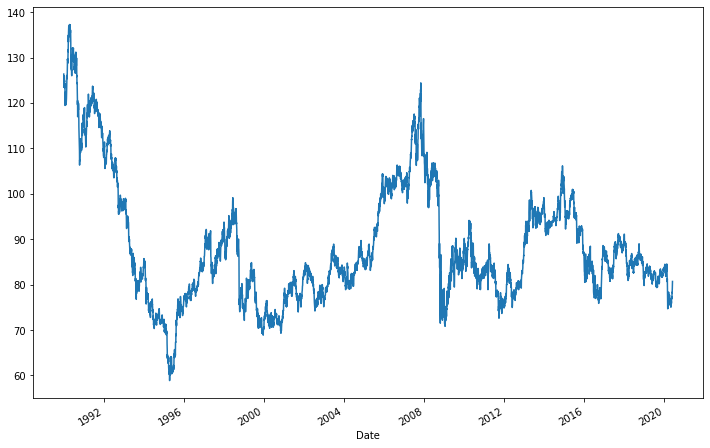

In [143]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize=(12,8))

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** This chart has both a long term/overall downtrend as well as a short term downtrend, with the short term also showing less volatility.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [144]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [145]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
df = pd.DataFrame()
df['Price'] = cad_jpy_df.Price
df['noise'] = ts_noise
df['trend'] = ts_trend

df

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037
...,...,...,...
2020-05-29,78.29,-0.503961,78.793961
2020-06-01,79.27,0.218939,79.051061
2020-06-02,80.40,1.088117,79.311883


<AxesSubplot:title={'center':'Price vs Trend'}, xlabel='Date'>

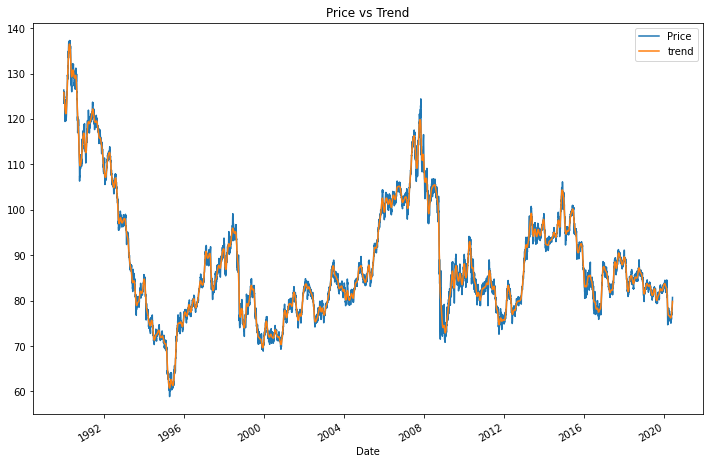

In [146]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
df[['Price', 'trend']].plot(figsize=(12, 8), title='Price vs Trend')

#answer This chart has both a long term/overall downtrend as well as a short term downtrend, with less volatility.

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** This chart has both a long term/overall downtrend as well as a short term downtrend, with the short term also showing less volatility. On the extremly short time frame, at the beggining of 2020 it can be seen their is a small reversal in price that also broke through and reversed the trend line (orange).

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

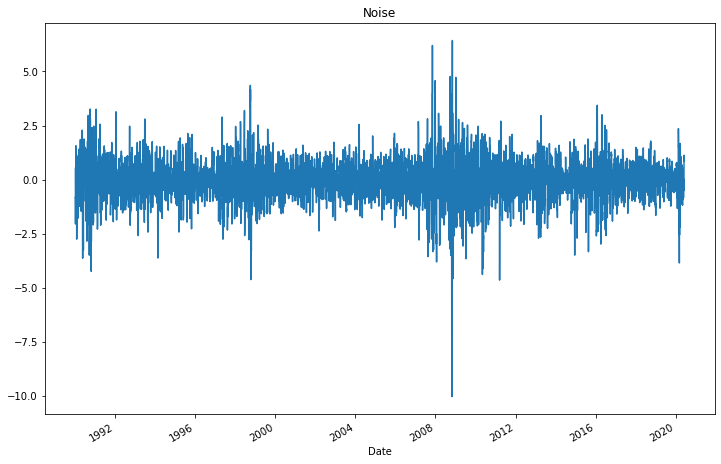

In [147]:
# Plot the Settle Noise
df.noise.plot(figsize=(12, 8), title='Noise')

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [148]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = pd.DataFrame()
returns['Returns'] = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.head()

,Returns
Date,
1990-01-03,-0.846720
1990-01-04,-1.468476
1990-01-05,0.874777
1990-01-08,-0.216798
1990-01-09,0.667901


In [149]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1)) 

# Fit the model and assign it to a variable called results
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23010D+00    |proj g|=  3.45568D-04

At iterate    5    f=  1.23010D+00    |proj g|=  3.60378D-05

At iterate   10    f=  1.23010D+00    |proj g|=  3.51208D-04


 This problem is unconstrained.



At iterate   15    f=  1.23008D+00    |proj g|=  2.32743D-03

At iterate   20    f=  1.23007D+00    |proj g|=  2.26485D-05

At iterate   25    f=  1.23007D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   2.220D-08   1.230D+00
  F =   1.2300678291595069     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [150]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Wed, 27 Apr 2022   AIC                          19513.955
Time:                        22:59:02   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1698           +0.0000j           42.1698            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

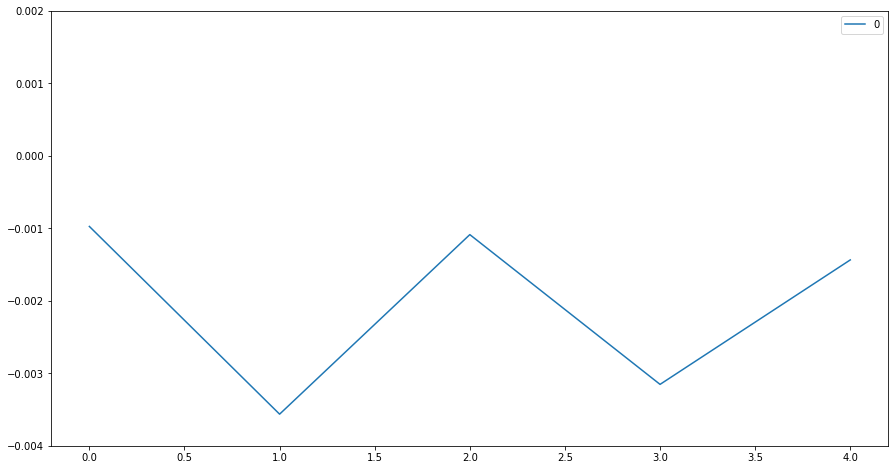

In [151]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="",figsize=(15,8),ylim=[-0.004,0.002]) 

In [157]:
#p value?
from statsmodels.tsa.stattools import adfuller

adfuller(returns.Returns)

#personal notes:
#if second value is < 0.05, then can assume process is stationary 
#if second value is > 0.05, then there is not enough evidence to reject the null hypothesis 
#therefore process is  non-stationary 

(-19.0038637954444,
 0.0,
 23,
 7904,
 {'1%': -3.4311776094390547,
  '5%': -2.861905743461419,
  '10%': -2.5669646805907993},
 19420.66542277558)

**Question:** Based on the p-value, is the model a good fit?

**Answer:** The P-Value constant in the summary results is 0.0 (second number outout from the cell above), this means and proves that the process (Returns) are stationary. So yes the model is a good fit. 


---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [158]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(df['Price'], order=(5, 1, 1))


# Fit the model
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10313D+00    |proj g|=  1.93001D-04

At iterate    5    f=  1.10313D+00    |proj g|=  5.79536D-06

At iterate   10    f=  1.10313D+00    |proj g|=  3.35287D-05

At iterate   15    f=  1.10313D+00    |proj g|=  4.83391D-05

At iterate   20    f=  1.10313D+00    |proj g|=  4.88498D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     34      1     0     0   8.882D-08   1.103D+00
  F =   1.1031309576186830     

CONVERG

In [159]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Wed, 27 Apr 2022   AIC                          17507.244
Time:                        23:09:34   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.855      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7703j            1.9266           -0.0655
AR.2            1.7660           +0.7703j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1894           +0.0000j            2.1894            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

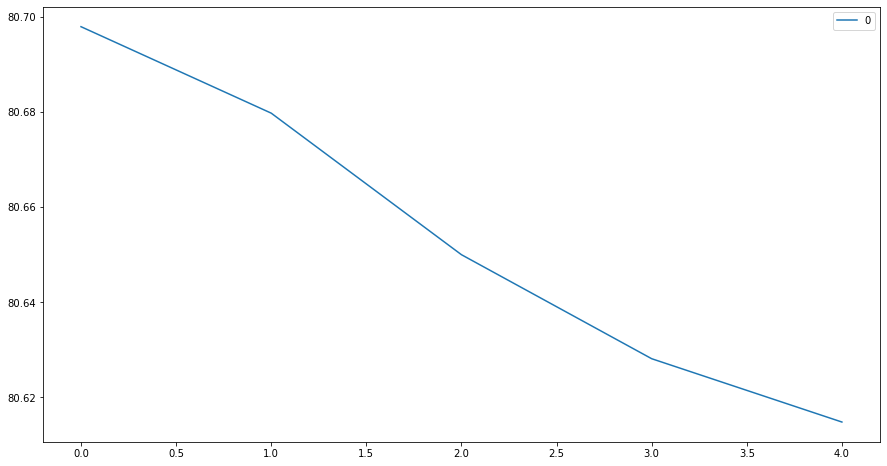

In [160]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(figsize=(15, 8), title="") 

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The model forecasts a consistent downtrend over the next 5 days. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [166]:
import arch as arch

In [168]:
# Estimate a GARCH model:
model = arch(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results = model.fit(disp='off')

TypeError: 'module' object is not callable

In [165]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Wed, 27 Apr 2022   AIC                          17507.244
Time:                        23:11:18   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.855      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7703j            1.9266           -0.0655
AR.2            1.7660           +0.7703j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1894           +0.0000j            2.1894            0.0000
-----------------------------------------------------------------------------
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [ ]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

In [ ]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above

#trial test
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

In [ ]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** YOUR ANSWER HERE

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * YOUR ANSWER HERE

2. Is the risk of the yen expected to increase or decrease?
    * YOUR ANSWER HERE

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * YOUR ANSWER HERE